# Tensorflow Implementation (part_2)<hr>

In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot = False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
X = mnist.train.images
Y = mnist.train.labels


st = None
Normal = tf.contrib.distributions.Normal
Bernoulli = tf.contrib.distributions.Bernoulli

In [6]:
class DenseLayer(object):
    def __init__(self, M1, M2, f = tf.nn.relu):
        self.W = tf.Variable(tf.random_normal(shape=(M1, M2)) * 2 / np.sqrt(M1))
        self.b = tf.Variable(np.zeros(M2).astype(np.float32))
        self.f = f
    
    def forward(self, X):
        return self.f(tf.matmul(X, self.W) + self.b)
    

class VariationalAutoencoder:
    def __init__(self, D, hidden_layer_sizes):
        # hidden_layer_sizes specifies the size of every layer
        # in the encoder
        # up to the final hidden layer Z
        # the decoder will have the reverse shape
        
        # represents a batch of training data
        self.X = tf.placeholder(tf.float32, shape=(None, D))
        
        # encoder
        self.encoder_layers = []
        M_in = D
        for M_out in hidden_layer_sizes[:-1]:
            h = DenseLayer(M_in, M_out)
            self.encoder_layers.append(h)
            M_in = M_out
        
        # for convenience, we'll refer to the final encoder size as M
        # also the input to the decoder size
        M = hidden_layer_sizes[-1]
        
        # the encoder's final layer output is unbounded
        # so there is no activation function
        # we also need 2 times as many units as specified by M_out
        # since there needs be M_out means + M_out variances
        h = DenseLayer(M_in, 2 * M, f = lambda x: x)
        self.encoder_layers.append(h)
        
        # get the mean and variance / std dev of Z.
        # note that the variance must be > 0
        # we can get a sigma (standard dev) > 0 from an unbounded variable by
        # passing it through the softplus function.
        # add a small amount for smoothing
        currunt_layer_value = self.X
        for layer in self.encoder_layers:
            currunt_layer_value = layer.forward(currunt_layer_value)
        self.means = currunt_layer_value[:,:M]
        self.stddev = tf.nn.softplus(currunt_layer_value[:,M:] + 1e-6)
        
        
        # get a sample of Z
        # we need to use a stochastic tensor
        # in order for the errors to be backpropagated past this point
        standard_normal = Normal(
            loc=np.zeros(M, dtype=np.float32),
            scale=np.ones(M, dtype=np.float32)
        )
        e = standard_normal.sample(tf.shape(self.means)[0])
        self.Z = e * self.stddev + self.means
        
        # note: this also works because Tensorflow
        # now does the "magic" for you 
        # n= Normal(
        #   loc = self.means,
        #   scale = self.stddev,
        # )
        # self.Z = n.sample()
        
        
        
        # decoder
        self.decoder_layers = []
        M_in = M
        for M_out in reversed(hidden_layer_sizes[:-1]):
            h = DenseLayer(M_in, M_out)
            self.decoder_layers.append(h)
            M_in = M_out
        
        # the decoder's final layer should technically go through a sigmoid
        # so that the final output is a binary probability (e.g. Bernoulli)
        # but Bernoulli accpets logits (pre-sigmoid) so we will take those
        # so no activation function is needed at the final layer
        h = DenseLayer(M_in, D, f = lambda x: x)
        self.decoder_layers.append(h)
        
        # get the logits
        currunt_layer_value = self.Z
        for layer in self.decoder_layers:
            currunt_layer_value = layer.forward(currunt_layer_value)
        logits = currunt_layer_value
        posterior_predictive_logits = logits # save for later
        
        # get the output
        self.X_hat_distribution = Bernoulli(logits=logits)
        
        # take samples from X_hat
        # we will call this the posterior predictive sample
        self.posterior_predictive = self.X_hat_distribution.sample()
        self.posterior_predictive_probs = tf.nn.sigmoid(logits)
        
        
        # take sample from a Z ~ N(0, 1)
        # and put it through the decoder
        # we will call this the prior predictive sample
        standard_normal = Normal(
            loc=np.zeros(M, dtype=np.float32),
            scale=np.ones(M, dtype=np.float32)
        )
        
        Z_std = standard_normal.sample(1)
        currunt_layer_value = Z_std
        for layer in self.decoder_layers:
            currunt_layer_value = layer.forward(currunt_layer_value)
        logits = currunt_layer_value
        
        prior_predictive_dist = Bernoulli(logits=logits)
        self.prior_predictive = prior_predictive_dist.sample()
        self.prior_predictive_probs = tf.nn.sigmoid(logits)
        
        
        # prior predictive from input
        # only used for generating visualization
        self.Z_input = tf.placeholder(tf.float32, shape=(None, M))
        currunt_layer_value = self.Z_input
        for layer in self.decoder_layers:
            currunt_layer_value = layer.forward(currunt_layer_value)
        logits = currunt_layer_value
        self.prior_predictive_from_input_probs = tf.nn.sigmoid(logits)
        
        
        # now build the cost
        kl = -tf.log(self.stddev) + 0.5 * (self.stddev**2 + self.means**2) - 0.5
        kl = tf.reduce_sum(kl, axis=1)
        expected_log_likelihood = tf.reduce_sum(
            self.X_hat_distribution.log_prob(self.X),1
        )
        
        # equivalent
        # expected_log_likelihood = -tf.nn.sigmoid_cross_entropy_with_logits(
        #   labels = self.X,
        #   logits = posterior_predictive_logits
        # )
        # expected_log_likelihood = -tf.reduce_sum(expected_log_likelihood, 1)
        
        
        
        
        self.elbo = tf.reduce_sum(expected_log_likelihood - kl)
        self.train_op = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(-self.elbo)
        
        # set up session and variables for later
        self.init_op = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(self.init_op)
        
        
    def fit(self, X, epochs = 30, batch_sz = 200):
        costs = []
        n_batches = len(X) // batch_sz
        print("n_batches: ", n_batches)
        for i in range(epochs):
            print('epochs: ', i)
            np.random.shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz:(j+1)*batch_sz]
                _, c = self.sess.run([self.train_op, self.elbo], feed_dict = {self.X:batch})
                c /= batch_sz
                costs.append(c)
                if j % 100  == 0:
                    print('iter: %d, cost: %.3f' % (j,c))
        plt.plot(costs)
        plt.show()
        
        
    def transform(self, X):
        return self.sess.run(self.means,feed_dict = {self.X:X})
    
    def prior_predictive_with_input(self, Z):
        return self.sess.run(
            self.prior_predictive_from_input_probs,
            feed_dict = {self.Z_input : Z}
        )
    
    def posterior_predictive_sample(self, X):
        # returns a sample from p(x_new | X)
        return self.sess.run(self.posterior_predictive, feed_dict={self.X: X})

    def prior_predictive_sample_with_probs(self):
        # returns a sample from p(x_new | z), z ~ N(0, 1)
        return self.sess.run((self.prior_predictive, self.prior_predictive_probs))  

In [14]:
def main(X, epochs = 30, batch_sz = 200):
    # convert X to binary variable,
    # this isn't necessary
    X = (X > 0.5).astype(np.float32)
    
    
    vae = VariationalAutoencoder(784, [200, 100])
    vae.fit(X, epochs = epochs, batch_sz = batch_sz)
    
    # plot reconstruction
    done = False
    while not done:
        i = np.random.choice(len(X))
        x = X[i]
        im = vae.posterior_predictive_sample([x]).reshape(28, 28)
        plt.subplot(1,2,1)
        plt.imshow(x.reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.subplot(1,2,2)
        plt.imshow(im.reshape(28, 28), cmap='gray')
        plt.title("Sampled")
        plt.show()
        
        ans = input("Generate another?")
        if ans and ans[0] in ('n' or 'N'):
            done = True

n_batches:  110
epochs:  0
iter: 0, cost: -1522.228
iter: 100, cost: -212.858
epochs:  1
iter: 0, cost: -203.981
iter: 100, cost: -165.681
epochs:  2
iter: 0, cost: -167.786
iter: 100, cost: -149.945
epochs:  3
iter: 0, cost: -152.051
iter: 100, cost: -143.694
epochs:  4
iter: 0, cost: -142.268
iter: 100, cost: -134.706
epochs:  5
iter: 0, cost: -137.166
iter: 100, cost: -135.212
epochs:  6
iter: 0, cost: -133.337
iter: 100, cost: -126.611
epochs:  7
iter: 0, cost: -127.805
iter: 100, cost: -123.523
epochs:  8
iter: 0, cost: -122.834
iter: 100, cost: -121.706
epochs:  9
iter: 0, cost: -118.785
iter: 100, cost: -116.259
epochs:  10
iter: 0, cost: -118.103
iter: 100, cost: -117.723
epochs:  11
iter: 0, cost: -118.888
iter: 100, cost: -113.993
epochs:  12
iter: 0, cost: -114.976
iter: 100, cost: -113.474
epochs:  13
iter: 0, cost: -113.531
iter: 100, cost: -108.322
epochs:  14
iter: 0, cost: -108.333
iter: 100, cost: -109.433
epochs:  15
iter: 0, cost: -107.611
iter: 100, cost: -110.552
e

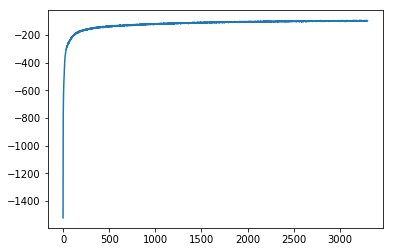

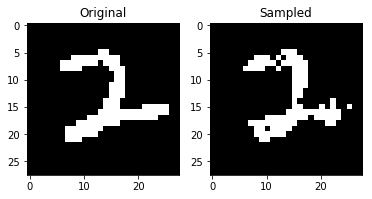

Generate another?n


AttributeError: 'tuple' object has no attribute 'reshape'

In [15]:
main(X, epochs = 30, batch_sz=500)

Why do the prior predictive samples generally look worse?<br>
Perhaps no actual images mapped to the latent vector we happened to sample.<br>
The latent vaector could also correspond to the area on the border between 2 or more different digits.